# Cartera

Autores:
>Santiago Osorio Duque 

>Johan S. Méndez

## Objetivo:
Identificar si un registro necesita gestión de cobro con mora a mayor de 30 días

## Necesidad:
Poder tomar acciones tempranas y realizar las respectivas gestiones a los registros que necesitarán dado una predicción de mora de 30 días. Esto con el objetivo de reducir costos además de evitar la reducción de liquidez

## Análisis de información 
Se realizará limpieza de los datos que fueron suministrados. 
1. Comportamiento variables consignadas en la base de datos 
2. Encontrar relaciones entre ellas
3. Evolución a través del tiempo 

In [1]:
# Modulos escritos
from connect_database import connect
from low_variance import variance_threshold_selector
from outliers import Remove_Outliers, remove_records_with_outliers
from split_data import split_stratified

# Librerias 
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# skelearn modules
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OneHotEncoder, StandardScaler)
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score

import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier

Se hace la lectura de la base de datos utilizando el módulo _connect_ que se encuentra escrito dentro del archivo __connect_database.py__. Con esto se establece la conexión a las bases guardadas en azure. A continuación se listan las bases a las cuales se quiere hacer la conexión 

In [3]:
server   = "carterasvr.database.windows.net"
database = "cartera"
username = "consulta"
password = "D4t4b1z2.123"

# Se establece la conexión 
cnxn = connect(server, database, username, password)

Petición SQL a la base de datos. Se almacena dentro de un marco de datos de Pandas

In [4]:
sql = ("""SELECT HIST_CARTERA.*, REGIONES.ID_REGION_NATURAL, REGIONES.NOMBRE AS REGION
FROM HIST_CARTERA LEFT JOIN
     (SELECT DIM_GEOGRAFIA.ID_GEOGRAFIA, DIM_GEOGRAFIA.ID_REGION_NATURAL, DRN.NOMBRE
FROM DIM_GEOGRAFIA
LEFT JOIN DIM_REGION_NATURAL DRN on DIM_GEOGRAFIA.ID_REGION_NATURAL = DRN.ID_REGION_NATURAL) REGIONES
ON HIST_CARTERA.ID_GEOGRAFIA = REGIONES.ID_GEOGRAFIA""")

data = pd.read_sql(sql, cnxn)


In [5]:
data

,ID_FECHA_CONSULTADA,ANIO_CARTERA,MES_CARTERA,ANIOMES_CARTERA,NUMERO_CONTRATO,TIPO_IDENTIFICACION,IDENTIFICACION,SEXO,INGRESO,REPUTACION_CLIENTE,...,CANTIDAD_FACTURAS_CON_MORA,FECHA_REGISTRO_CARTERA,FECHA_COBRO,FECHA_PAGO,FECHA_RECAUDO,ID_CONTRATO,ID_CLIENTE,ID_GEOGRAFIA,ID_REGION_NATURAL,REGION
0,20181201.0,2018,11,201811,758589809482,5,30567722,F,2454284.0,4.0,...,0.0,2018-11-23,2018-12-08,2018-11-26,2018-11-27,8689.0,3929.0,54670.0,2.0,Centro Oriente
1,20190101.0,2018,12,201812,830910315567,2,11642038,M,5492814.0,5.0,...,0.0,2018-12-23,2019-01-07,2018-12-27,2018-12-28,11372.0,5614.0,54670.0,2.0,Centro Oriente
2,20190101.0,2018,12,201812,915320322651,3,72850794,M,5946697.0,3.0,...,0.0,2018-12-23,2019-01-07,2018-12-24,2018-12-25,7070.0,6182.0,5480.0,4.0,Eje Cafetero - Antioquia
3,20190101.0,2018,12,201812,754486263805,5,71620041,F,5489184.0,5.0,...,0.0,2018-12-23,2019-01-07,2019-01-01,2019-01-02,10940.0,2145.0,5480.0,4.0,Eje Cafetero - Antioquia
4,20190201.0,2019,01,201901,482290887380,1,46788645,F,5005455.0,5.0,...,0.0,2019-01-23,2019-02-07,2019-01-27,2019-01-28,12811.0,3294.0,5040.0,4.0,Eje Cafetero - Antioquia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182774,20150801.0,2015,07,201507,396932713330,3,28314231,M,1806612.0,4.0,...,0.0,2015-07-23,2015-08-07,2015-07-25,2015-07-26,6678.0,10605.0,25426.0,2.0,Centro Oriente
182775,20150801.0,2015,07,201507,442296544038,4,78176770,M,609600.0,4.0,...,0.0,2015-07-23,2015-08-07,2015-07-23,2015-07-24,5952.0,8766.0,27205.0,6.0,Pacífico
182776,20150801.0,2015,07,201507,700030420895,1,68350115,M,2177628.0,5.0,...,0.0,2015-07-23,2015-08-07,2015-07-30,2015-07-31,12480.0,9006.0,81300.0,5.0,Llano
182777,20150801.0,2015,07,201507,919730907694,2,7059347,F,1539082.0,4.0,...,0.0,2015-07-23,2015-08-07,2015-08-04,2015-08-05,8604.0,797.0,52256.0,6.0,Pacífico


### Campos Agregados 

Inclusión del primer campo __FECHA_CONSULTADA__, la fecha viene por defecto en la base de datos con el formato (__20181201.0__). Para el manejo de datos se cambia el formato para el tipo (__2018-12-01__) en el formato _datetime_ de pandas

In [6]:
data["FECHA_CONSULTADA"] = pd.to_datetime(data["ID_FECHA_CONSULTADA"].astype("int").astype("str"), format = "%Y-%m-%d")

Segundo campo agregado __DIAS_CONOCIMIENTO_FACTURA__ consigna los dias de diferencia entre el registro de cartera y la consulta, es decir, cuantos días el usuario conoce su retraso. Además se normaliza para que se tenga en el campo de datos sin unidades y como punto flotante

In [7]:
data["DIAS_CONOCIMIENTO_FACTURA"] = (data["FECHA_CONSULTADA"] - data["FECHA_REGISTRO_CARTERA"])/np.timedelta64(1, "D")

Tercer campo agregado __DIAS_MORA__. Se puede inferir con los campos de la base los días de mora del usuario, si el resultado es un valor negativo se hizo el pago antes del registro de la fecha de cobro. Se pueden presentar varios casos , pero es importante conocer la forma en que el banco hace el cobro para poder determinar si en realidad la mora se relaciona con atraso o con una mala política de cobro del banco.

Para los valores perdidos se van a utilizar una columna transitoria etiquetada con _fixed_ que va poner 1 día de mora a la base de datos. Luego de esto se utiliza esta variable transitoria para calcular la mora con la fecha de consulta del usuario

In [8]:
data["DIAS_MORA"] = (data["FECHA_PAGO"] - data["FECHA_COBRO"])/np.timedelta64(1, "D")

# Definicion de columna auxiliar
data["fixem"] = 0
# Rellenar valores perdidos con un dia de mora
data.at[data["DIAS_MORA"].isna(), "fixem"] = 1
# Calculo de la mora desde la fecha consultada 
data.at[data["fixem"]==1, "DIAS_MORA"] = (data[data["fixem"]==1]["FECHA_CONSULTADA"] - data[data["fixem"]==1]["FECHA_COBRO"])/np.timedelta64(1, "D")
# Descarte de la columna provisional
data = data.drop(columns="fixem")

Cuarto campo agregado __GESTION_COBRO__. Se identifican los usuarios que tengan mas de 30 días de mora para la identificación en la gestión de cobro

In [9]:
data["GESTION_COBRO"] = (data["DIAS_MORA"] > 30).astype(int)

Quinto campo agregado __SALDADA__. Se tiene para identificar quien esta con todas sus obligaciones saldadas

In [10]:
data["SALDADA"] = (~data["FECHA_PAGO"].isna()).astype("int")

Se construye entonces la base de datos con las columnas que se van a utilizar

In [11]:
keys = ["NUMERO_CONTRATO", "TIPO_IDENTIFICACION", "IDENTIFICACION", "SEXO", "INGRESO",
        "REGION", "REPUTACION_CLIENTE", "GARANTIA_COLATERAL_CLIENTE", "NIVEL_RIESGO_CLIENTE", "CAPACIDAD_CLIENTE", "CAPITAL_CLIENTE",
        "CIUDAD", "PROVINCIA_ESTADO_DEPARTAMENTO", "PLAZO_PACTADO", "CANTIDAD_CUOTAS_PAGADAS", "CANTIDAD_CUOTAS_PENDIENTES",
        "PORCENTAJE_INTERES_CORRIENTE_EA", "PORCENTAJE_INTERES_MORA_EA", "SALDO_CAPITAL_CONTRATO", "VALOR_INICIAL", "CANTIDAD_FACTURAS",
        "ID_CONTRATO", "ID_CLIENTE", "DIAS_MORA", "GESTION_COBRO", "DIAS_CONOCIMIENTO_FACTURA",
        "SALDADA"
       ]
DATA = data[keys]


Para saber si un usuario está en mora se crea a partir de la variable __GESTION_COBRO__ una variable binaria que clasifica al usuario en dos grupos, aquel que esté en mora(1) y aquel que no(0). 



## Descripción de las variables 

Se cambia el nombre de la variable respuesta 

In [12]:
DATA.rename(columns={"GESTION_COBRO": "RESPONSE"}, inplace=True)

# Debug this cell

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


### Variable objetivo

Se evidencia como están distribuidos los morosos

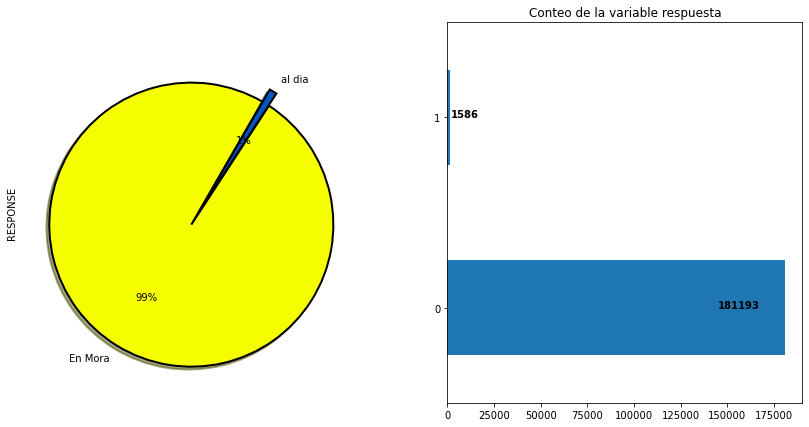

In [13]:
plt.figure(figsize=(14,7))

plt.subplot(121)
DATA["RESPONSE"].value_counts().plot.pie(autopct="%1.0f%%", 
                                         colors=sns.color_palette("prism",7), 
                                         startangle=60, 
                                         labels=["En Mora", "al dia"],
                                         wedgeprops={"linewidth":2, "edgecolor":"k"},
                                         explode=[.1, 0],
                                         shadow=True
                                        )
plt.subplot(122)
ax = DATA["RESPONSE"].value_counts().plot(kind="barh")
ax.text(DATA["RESPONSE"].value_counts()[0] * 0.8, 0, DATA["RESPONSE"].value_counts()[0], weight="bold")
ax.text(DATA["RESPONSE"].value_counts()[1]*1.1 , 1, DATA["RESPONSE"].value_counts()[1], weight="bold")

plt.title("Conteo de la variable respuesta")
plt.show()




Se hace la descripción por tipos de variables en la base de datos 

In [14]:
columns_object  = DATA.select_dtypes(include=["object"]).columns
columns_numeric = DATA.select_dtypes(include=["int", "float"]).columns
DATA[columns_numeric]

,INGRESO,REPUTACION_CLIENTE,GARANTIA_COLATERAL_CLIENTE,NIVEL_RIESGO_CLIENTE,CAPACIDAD_CLIENTE,CAPITAL_CLIENTE,PLAZO_PACTADO,CANTIDAD_CUOTAS_PAGADAS,CANTIDAD_CUOTAS_PENDIENTES,PORCENTAJE_INTERES_CORRIENTE_EA,PORCENTAJE_INTERES_MORA_EA,SALDO_CAPITAL_CONTRATO,VALOR_INICIAL,CANTIDAD_FACTURAS,ID_CONTRATO,ID_CLIENTE,DIAS_MORA,RESPONSE,DIAS_CONOCIMIENTO_FACTURA,SALDADA
0,2454284.0,4.0,4.0,4.0,1.0,4.0,96.0,61.0,35.0,8.95,18.95,6487016.0,17793000.0,62,8689.0,3929.0,-12.0,0,8.0,1
1,5492814.0,5.0,2.0,5.0,3.0,5.0,60.0,3.0,57.0,7.45,22.20,14700300.0,15474000.0,4,11372.0,5614.0,-11.0,0,9.0,1
2,5946697.0,3.0,3.0,1.0,5.0,3.0,84.0,27.0,57.0,15.10,18.95,34162009.0,50344000.0,28,7070.0,6182.0,-14.0,0,9.0,1
3,5489184.0,5.0,1.0,5.0,5.0,4.0,96.0,6.0,90.0,11.45,18.95,58750314.0,62667000.0,7,10940.0,2145.0,-6.0,0,9.0,1
4,5005455.0,5.0,5.0,5.0,5.0,2.0,48.0,9.0,39.0,15.10,20.99,5231686.0,6439000.0,10,12811.0,3294.0,-11.0,0,9.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182774,1806612.0,4.0,3.0,5.0,4.0,1.0,96.0,12.0,84.0,10.30,17.45,32809004.0,37496000.0,13,6678.0,10605.0,-13.0,0,9.0,1
182775,609600.0,4.0,1.0,2.0,3.0,4.0,96.0,2.0,94.0,15.10,18.95,38539020.0,39359000.0,3,5952.0,8766.0,-15.0,0,9.0,1
182776,2177628.0,5.0,1.0,2.0,1.0,1.0,84.0,5.0,79.0,12.20,20.99,38301835.0,40726000.0,6,12480.0,9006.0,-8.0,0,9.0,1
182777,1539082.0,4.0,3.0,1.0,5.0,4.0,96.0,3.0,93.0,15.10,18.95,54101780.0,55847000.0,4,8604.0,797.0,-3.0,0,9.0,1


### Variables Numéricas

### Verificación de baja varianza


> Hay muchos modelos en los que los predictores con un único valor (también conocidos como "predictores de varianza cero") harán que el modelo falle. Dado que se ajustarán los modelos utilizando métodos de remuestreo, una muestra aleatoria del conjunto de entrenamiento puede dar como resultado que algunos predictores con más de un valor único se conviertan en un predictor de varianza cero. Estos son los llamados "predictores de varianza cercana a cero" pueden causar problemas numéricos durante el remuestreo para algunos modelos, como la regresión lineal.

Por esta razón es necesario verificar todos las variables predictivas numéricas para evitar errores en las regresiones

In [16]:
%load_ext autoreload
%autoreload 2

variance_threshold_selector(DATA[columns_numeric])

,INGRESO,REPUTACION_CLIENTE,GARANTIA_COLATERAL_CLIENTE,NIVEL_RIESGO_CLIENTE,CAPACIDAD_CLIENTE,CAPITAL_CLIENTE,PLAZO_PACTADO,CANTIDAD_CUOTAS_PAGADAS,CANTIDAD_CUOTAS_PENDIENTES,PORCENTAJE_INTERES_CORRIENTE_EA,PORCENTAJE_INTERES_MORA_EA,SALDO_CAPITAL_CONTRATO,VALOR_INICIAL,CANTIDAD_FACTURAS,ID_CONTRATO,ID_CLIENTE,DIAS_MORA,DIAS_CONOCIMIENTO_FACTURA
0,2454284.0,4.0,4.0,4.0,1.0,4.0,96.0,61.0,35.0,8.95,18.95,6487016.0,17793000.0,62,8689.0,3929.0,-12.0,8.0
1,5492814.0,5.0,2.0,5.0,3.0,5.0,60.0,3.0,57.0,7.45,22.20,14700300.0,15474000.0,4,11372.0,5614.0,-11.0,9.0
2,5946697.0,3.0,3.0,1.0,5.0,3.0,84.0,27.0,57.0,15.10,18.95,34162009.0,50344000.0,28,7070.0,6182.0,-14.0,9.0
3,5489184.0,5.0,1.0,5.0,5.0,4.0,96.0,6.0,90.0,11.45,18.95,58750314.0,62667000.0,7,10940.0,2145.0,-6.0,9.0
4,5005455.0,5.0,5.0,5.0,5.0,2.0,48.0,9.0,39.0,15.10,20.99,5231686.0,6439000.0,10,12811.0,3294.0,-11.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182774,1806612.0,4.0,3.0,5.0,4.0,1.0,96.0,12.0,84.0,10.30,17.45,32809004.0,37496000.0,13,6678.0,10605.0,-13.0,9.0
182775,609600.0,4.0,1.0,2.0,3.0,4.0,96.0,2.0,94.0,15.10,18.95,38539020.0,39359000.0,3,5952.0,8766.0,-15.0,9.0
182776,2177628.0,5.0,1.0,2.0,1.0,1.0,84.0,5.0,79.0,12.20,20.99,38301835.0,40726000.0,6,12480.0,9006.0,-8.0,9.0
182777,1539082.0,4.0,3.0,1.0,5.0,4.0,96.0,3.0,93.0,15.10,18.95,54101780.0,55847000.0,4,8604.0,797.0,-3.0,9.0


Dos columnas fueron excluidas de la base de datos. __RESPONSE__ y __SALDADA__. La variable __RESPONSE__ corresponde a la variable objetivo y la variable __SALDADA__ se relaciona con ella. Por tanto no se remueve ninguna por baja varianza

### Eliminación de valores atípicos

En primer lugar se hace una revisión rápida a cada variable para saber si existe valores atípicos evidentes. Se hace la diferencia entre variables categóricas que están indexadas por números, estas se representan en diagramas de barras para ver la distribución de categorias. Para las variables numéricas se hace un diagrama de caja, este permite identificar valores atípicos rápidamente para elegir una estrategia de eliminación de valores atípicos

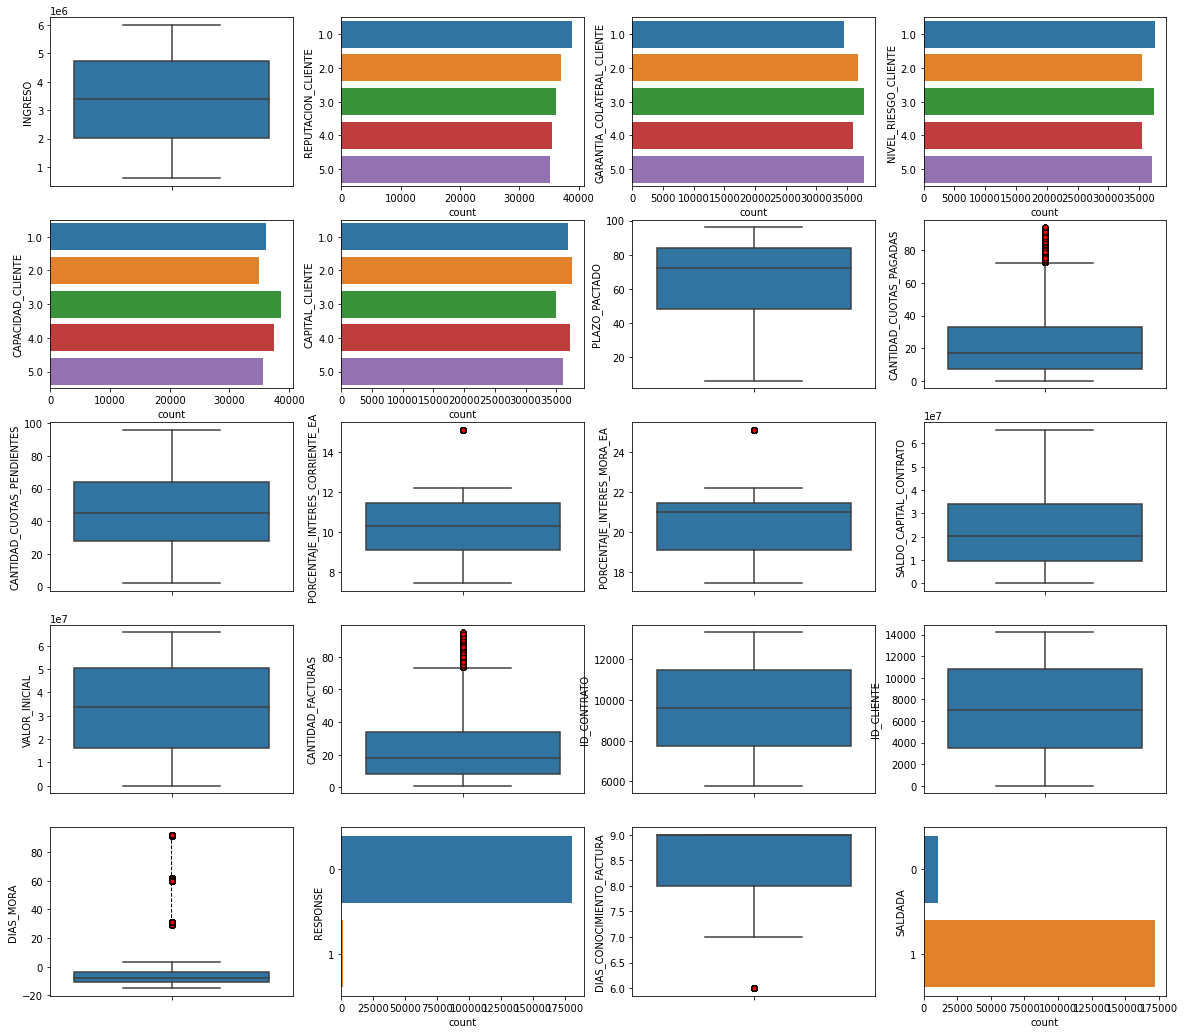

In [17]:
row = 5
columns = 4
fig, ax = plt.subplots(row, columns, figsize=(20, 18))

flp = dict(marker="o",
           markerfacecolor="red",
           markersize=5,
           linestyle="--",
           markeredgecolor="black")
count = 0

for i in range(row):
    for j in range(columns):
        plot_data = DATA[columns_numeric][DATA[columns_numeric].columns[count]]
        if DATA[columns_numeric].columns[count] == "REPUTACION_CLIENTE":
            sns.countplot(y=plot_data,ax=ax[i,j])
        elif DATA[columns_numeric].columns[count] == "GARANTIA_COLATERAL_CLIENTE":
            sns.countplot(y=plot_data,ax=ax[i,j])
        elif DATA[columns_numeric].columns[count] == "NIVEL_RIESGO_CLIENTE":
            sns.countplot(y=plot_data,ax=ax[i,j])
        elif DATA[columns_numeric].columns[count] == "CAPACIDAD_CLIENTE":
            sns.countplot(y=plot_data,ax=ax[i,j])
        elif DATA[columns_numeric].columns[count] == "CAPITAL_CLIENTE":
            sns.countplot(y=plot_data,ax=ax[i,j])
        elif DATA[columns_numeric].columns[count] == "RESPONSE":
            sns.countplot(y=plot_data,ax=ax[i,j])
        elif DATA[columns_numeric].columns[count] == "SALDADA":
            sns.countplot(y=plot_data,ax=ax[i,j])
        else:
            sns.boxplot(y=plot_data, ax=ax[i,j], flierprops=flp)
        count += 1


Se va a establecer un criterio claro en la detección de los valores atípicos, en este caso se utiliza la __puntuación-Z__. Este indicador cuantifica lo inusual de una observación cuando los datos siguen la distribución normal. Esto es aplicable con variables numéricas continuas, evidentemente las variables numéricas que pretenden clasificar los usuarios en grupos no están sujetas a este análisis. Esta puntuación consiste en considerar cierto numero de desviaciones estándar por encima(debajo) del promedio en la cual cae el valor en estudio. Por ejemplo una puntuación $Z=2$ indica que una observación está dos desviaciones estándar por encima del promedio, mientras que una puntuación $Z=-2$ significa que está dos desviaciones estándar por debajo de la media. Se define este indicador como:

$$Z = \frac{X-\mu}{\sigma}$$.

Cuanto más lejos este de cero la __puntuación-Z__ de una observación, más inusual será. Un valor de corte estándar en la literatura sera $(\pm 3)$.

Se hace una revisión de los datos bajo este criterio para ver si se hace necesario implementar una metodología de eliminación de Outliers.

In [18]:
# Columnas numéricas
ignore_columns = ["REPUTACION_CLIENTE", 
                  "GARANTIA_COLATERAL_CLIENTE",
                  "NIVEL_RIESGO_CLIENTE",
                  "CAPACIDAD_CLIENTE",
                  "CAPITAL_CLIENTE",
                  "RESPONSE",
                  "SALDADA"                  
                 ]

# Selección de datos numéricos
aux = DATA[columns_numeric]
# Exclusión de variables numéricas que se entienden como de 
# Clasificación 
aux = aux.loc[:, ~aux.columns.isin(ignore_columns)]
# definicion de la puntuación Z
z = (aux - aux.mean())/aux.std()

print("Puntuación Z (Identificación de columnas que cumplen el umbral)")
z[(z>3) | (z<-3)].sum()


Puntuación Z (Identificación de columnas que cumplen el umbral)


INGRESO                                0.000000
PLAZO_PACTADO                          0.000000
CANTIDAD_CUOTAS_PAGADAS             4221.445925
CANTIDAD_CUOTAS_PENDIENTES             0.000000
PORCENTAJE_INTERES_CORRIENTE_EA        0.000000
PORCENTAJE_INTERES_MORA_EA             0.000000
SALDO_CAPITAL_CONTRATO                 0.000000
VALOR_INICIAL                          0.000000
CANTIDAD_FACTURAS                   4215.905478
ID_CONTRATO                            0.000000
ID_CLIENTE                             0.000000
DIAS_MORA                          14403.750101
DIAS_CONOCIMIENTO_FACTURA              0.000000
dtype: float64

A partir de este análisis se tiene una idea clara de los valores atípicos a trabajar, se muestran a continuación

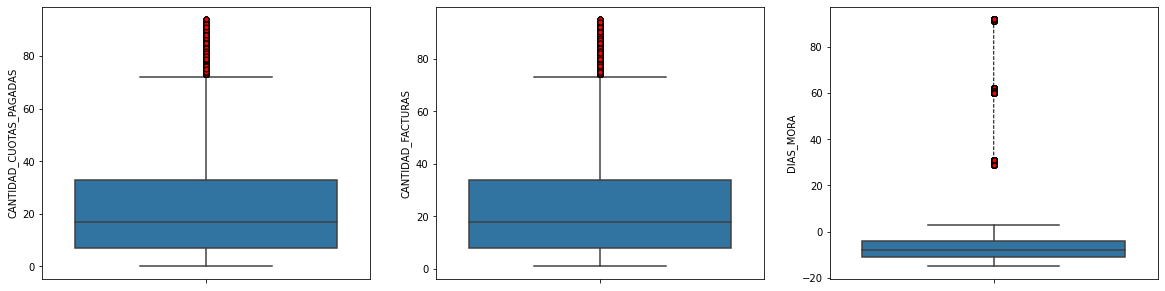

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

sns.boxplot(y=DATA["CANTIDAD_CUOTAS_PAGADAS"],ax=ax[0], flierprops=flp)
sns.boxplot(y=DATA["CANTIDAD_FACTURAS"],ax=ax[1], flierprops=flp)
sns.boxplot(y=DATA["DIAS_MORA"], ax=ax[2], flierprops=flp)


In [20]:
%load_ext autoreload
%autoreload 2

Outliers_columns = ["CANTIDAD_CUOTAS_PAGADAS", "CANTIDAD_FACTURAS", "DIAS_MORA"]
DATA[Outliers_columns]= Remove_Outliers(DATA[Outliers_columns])

# Debug

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


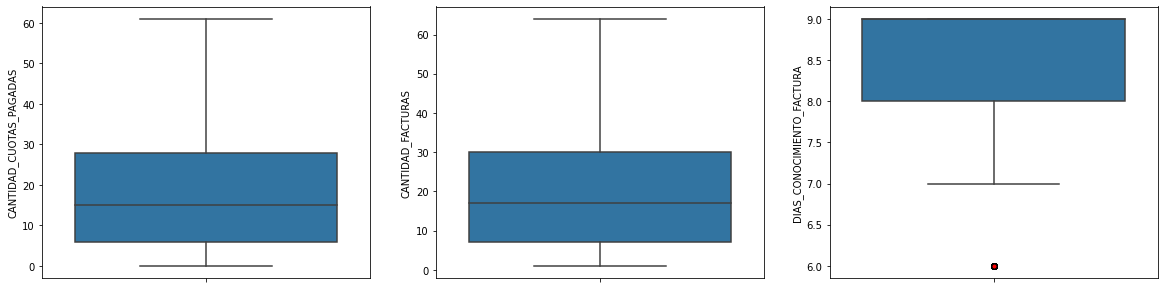

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

sns.boxplot(y=DATA["CANTIDAD_CUOTAS_PAGADAS"],ax=ax[0], flierprops=flp)
sns.boxplot(y=DATA["CANTIDAD_FACTURAS"],ax=ax[1], flierprops=flp)
sns.boxplot(y=DATA["DIAS_CONOCIMIENTO_FACTURA"], ax=ax[2], flierprops=flp)


### Variables del producto financiero

Se quiere ver alguna particularidad desde la función de distribución estadística de las variables numéricas de producto financiero. para esto se muestra 

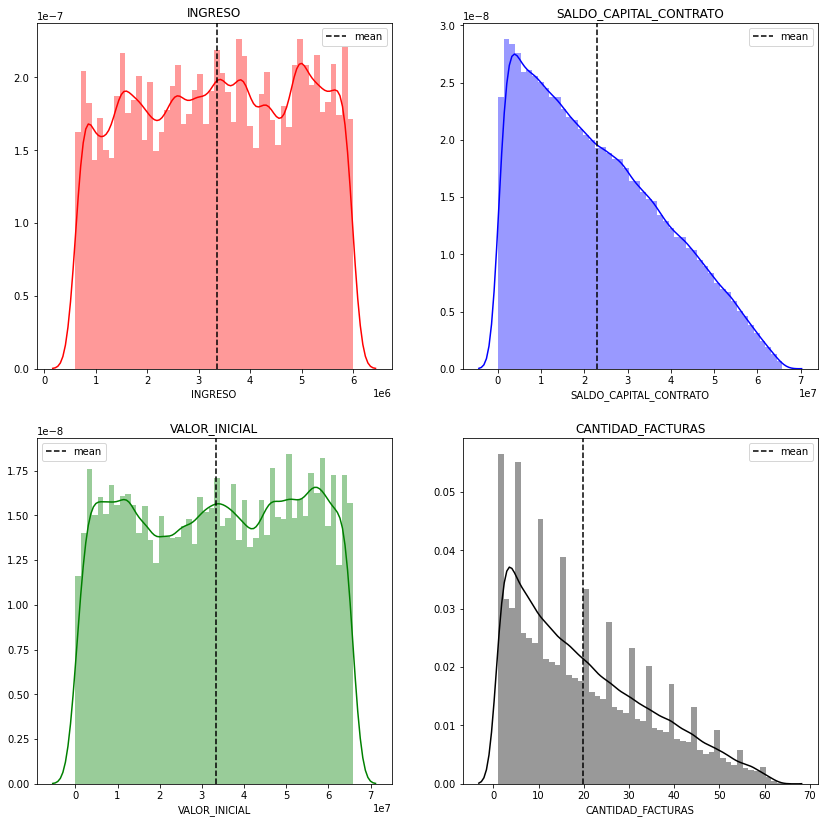

In [22]:
product_cols = ["INGRESO", "SALDO_CAPITAL_CONTRATO", "VALOR_INICIAL", "CANTIDAD_FACTURAS"]
colors = ["r", "b", "g", "k"]

plt.figure(figsize=(14,14))
for i,j,k in itertools.zip_longest(product_cols, range(len(product_cols)), colors):
    plt.subplot(2,2,j+1)
    sns.distplot(DATA[DATA[i].notnull()][i], color=k)
    plt.axvline(DATA[i].mean(), label="mean", linestyle="dashed", color="k")
    plt.legend(loc="best")
    plt.title(i)
    plt.subplots_adjust(hspace=0.2)

### Variables categóricas

### Sexo

Se hace evidente la distribución del Genero en la base de datos

Text(0.5, 1.0, 'Distribución de la variable RESPONSE por SEXO')

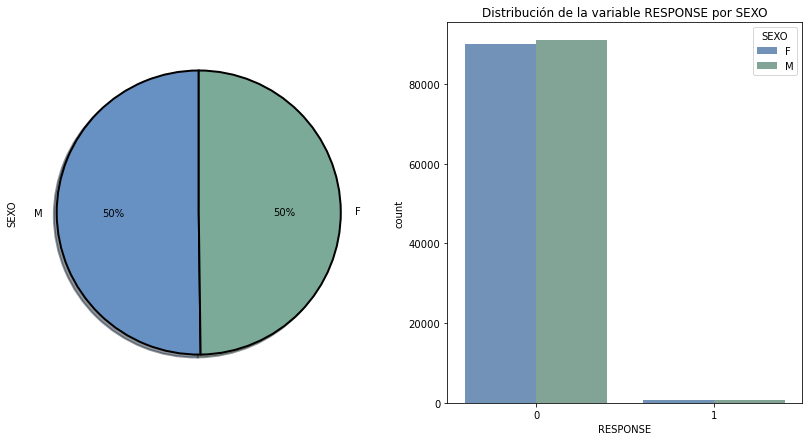

In [23]:
fig = plt.figure(figsize=(14,7))

plt.subplot(121)
data["SEXO"].value_counts().plot.pie(autopct="%1.0f%%",
                                     colors=["#6891C3", "#7CAA98"],
                                     startangle=90,
                                     wedgeprops={"linewidth":2, "edgecolor":"k"},
                                     shadow=True,
                                    )

plt.subplot(122)
ax = sns.countplot("RESPONSE", hue="SEXO", data=DATA, palette=["#6891C3", "#7CAA98"])
ax.set_title("Distribución de la variable RESPONSE por SEXO")


### Distribución por región 

Se evidencia que la mayoria de usuarios se encuentran concentrados en la región del "Centro Oriente"

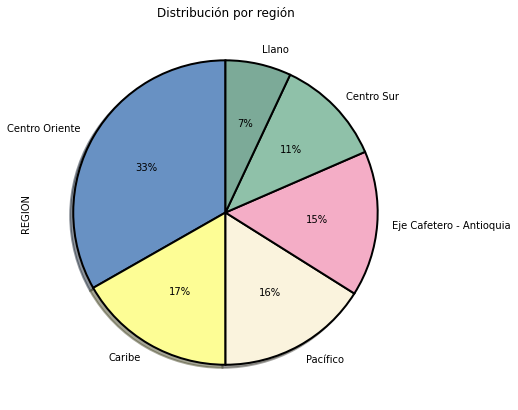

In [24]:
plt.figure(figsize=(14,7))
data["REGION"].value_counts().plot.pie(autopct="%1.0f%%",
                                       colors=["#6891C3", "#FDFD95", "#FAF3DD", "#F4ADC6", "#8FC1A9","#7CAA98"],
                                       startangle=90,
                                       wedgeprops={"linewidth":2, "edgecolor":"k"},
                                       shadow=True,
                                      )
plt.title("Distribución por región")
plt.show()

### Distribución por Departamento

En este respecto se tiene un pequeño error en la digitación de los datos, dado que se hace una diferencia entre bogotá y cundinamarca. La intención de esta variable es describir por departamentos, por lo tanto se unen los datos en la variable con "__Bogotá dC__" y "__Cundinamarca__"


<ipython-input-25-c8ead539d9b7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATA["PROVINCIA_ESTADO_DEPARTAMENTO"] = DATA["PROVINCIA_ESTADO_DEPARTAMENTO"].replace({'Bogotá d C.':'Cundinamarca'})


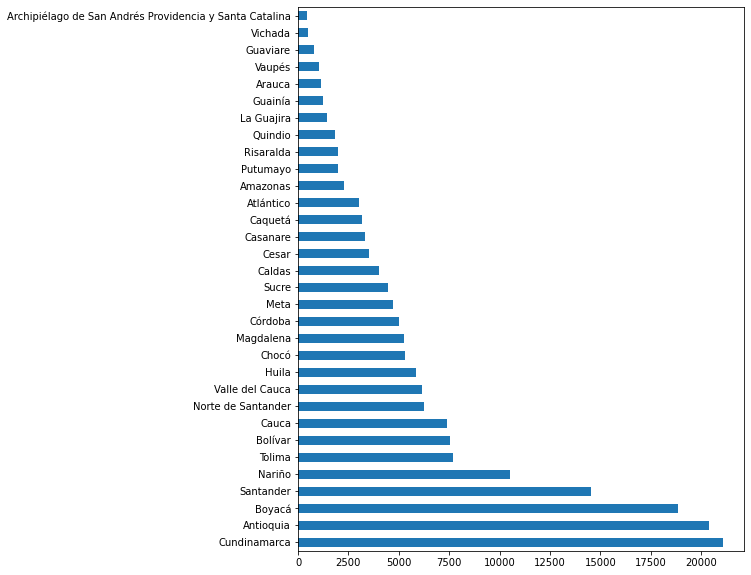

In [25]:
plt.figure(figsize=(8,10))

DATA["PROVINCIA_ESTADO_DEPARTAMENTO"] = DATA["PROVINCIA_ESTADO_DEPARTAMENTO"].replace({'Bogotá d C.':'Cundinamarca'})
DATA["PROVINCIA_ESTADO_DEPARTAMENTO"].value_counts().plot.barh()

# Debug

### Codificación de variables categóricas

Se comienza la construcción de la base de datos utilizando do técnicas __One Hot Encoding__ y __Label Encoding__. Para poder hacer la codificación se costruye una tubería y poder tener la transformación de variables de manera ágil. Se construye las variables que se encontraron categóricas, es claro que las variables que tengan string se incluyen en este grupo, sin embargo, en las variables numéricas se tienen variables de naturaleza categórica. 

Se omiten dos columnas. El número de contrato, que no aporta información significativa y el número de identificación porque nada más sirve en el caso de ubicar clientes

In [26]:
categorical =  [
#                 "NUMERO_CONTRATO", 
                "TIPO_IDENTIFICACION", 
#                 "IDENTIFICACION", 
                "SEXO", 
                "REGION", 
                "CIUDAD", 
                "PROVINCIA_ESTADO_DEPARTAMENTO",
                "REPUTACION_CLIENTE", 
                "GARANTIA_COLATERAL_CLIENTE", 
                "NIVEL_RIESGO_CLIENTE", 
                "CAPACIDAD_CLIENTE", 
                "CAPITAL_CLIENTE",
                "RESPONSE",
                "SALDADA"
               ]


In [28]:
categorical_model = [
                "TIPO_IDENTIFICACION", 
                "SEXO", 
                "REGION", 
                "CIUDAD", 
                "PROVINCIA_ESTADO_DEPARTAMENTO",
                "REPUTACION_CLIENTE", 
                "GARANTIA_COLATERAL_CLIENTE", 
                "NIVEL_RIESGO_CLIENTE", 
                "CAPACIDAD_CLIENTE", 
                "CAPITAL_CLIENTE",
               ]

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(DATA[categorical_model])
X = enc.transform(DATA[categorical_model]).toarray()

las variables que ya están listas para el modelo se irán almacenando en la variable $X$

In [29]:
print("Tamaño de la matriz = {}".format(X.shape))

Tamaño de la matriz = (182779, 1106)


### Correlación

Con las variables numéricas identificadas se hace la correlación correspondiente para ver si se puede reducir la complejidad de los datos, inicialmente se eliminan las variables que tienen NaN

In [30]:
# Conversión del tipo de datos pandas.core.indexes.base.Index a lista de python
aux_num = list(columns_numeric)
# Se descartan las columnas categoricas
aux_num = [i for i in aux_num if i not in categorical]
# Se agrega la variable respuesta para ver la correlación
aux_num = aux_num + ["RESPONSE"]
correlation_data = DATA[aux_num]
correlation_data

,INGRESO,PLAZO_PACTADO,CANTIDAD_CUOTAS_PAGADAS,CANTIDAD_CUOTAS_PENDIENTES,PORCENTAJE_INTERES_CORRIENTE_EA,PORCENTAJE_INTERES_MORA_EA,SALDO_CAPITAL_CONTRATO,VALOR_INICIAL,CANTIDAD_FACTURAS,ID_CONTRATO,ID_CLIENTE,DIAS_MORA,DIAS_CONOCIMIENTO_FACTURA,RESPONSE
0,2454284.0,96.0,NaN,35.0,8.95,18.95,6487016.0,17793000.0,NaN,8689.0,3929.0,NaN,8.0,0
1,5492814.0,60.0,3.0,57.0,7.45,22.20,14700300.0,15474000.0,4.0,11372.0,5614.0,-11.0,9.0,0
2,5946697.0,84.0,27.0,57.0,15.10,18.95,34162009.0,50344000.0,28.0,7070.0,6182.0,-14.0,9.0,0
3,5489184.0,96.0,6.0,90.0,11.45,18.95,58750314.0,62667000.0,7.0,10940.0,2145.0,-6.0,9.0,0
4,5005455.0,48.0,9.0,39.0,15.10,20.99,5231686.0,6439000.0,10.0,12811.0,3294.0,-11.0,9.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182774,1806612.0,96.0,12.0,84.0,10.30,17.45,32809004.0,37496000.0,13.0,6678.0,10605.0,-13.0,9.0,0
182775,609600.0,96.0,2.0,94.0,15.10,18.95,38539020.0,39359000.0,3.0,5952.0,8766.0,-15.0,9.0,0
182776,2177628.0,84.0,5.0,79.0,12.20,20.99,38301835.0,40726000.0,6.0,12480.0,9006.0,-8.0,9.0,0
182777,1539082.0,96.0,3.0,93.0,15.10,18.95,54101780.0,55847000.0,4.0,8604.0,797.0,-3.0,9.0,0


Se obvian los valores con NaN, en principio para ver como se comporta el modelo. tambien se elimina ID_CONTRATO y ID_CLIENTE porque son identificadores, no aportan nada significativo al modelo

In [31]:
# Se obvian columnas con NaN
NaN_columns = correlation_data.columns[correlation_data.isna().any()].tolist()
# se eliminan de las columnas 
aux_num = [i for i in aux_num if i not in NaN_columns]
aux_num.remove("ID_CONTRATO")
aux_num.remove("ID_CLIENTE")
correlation_data = DATA[aux_num]

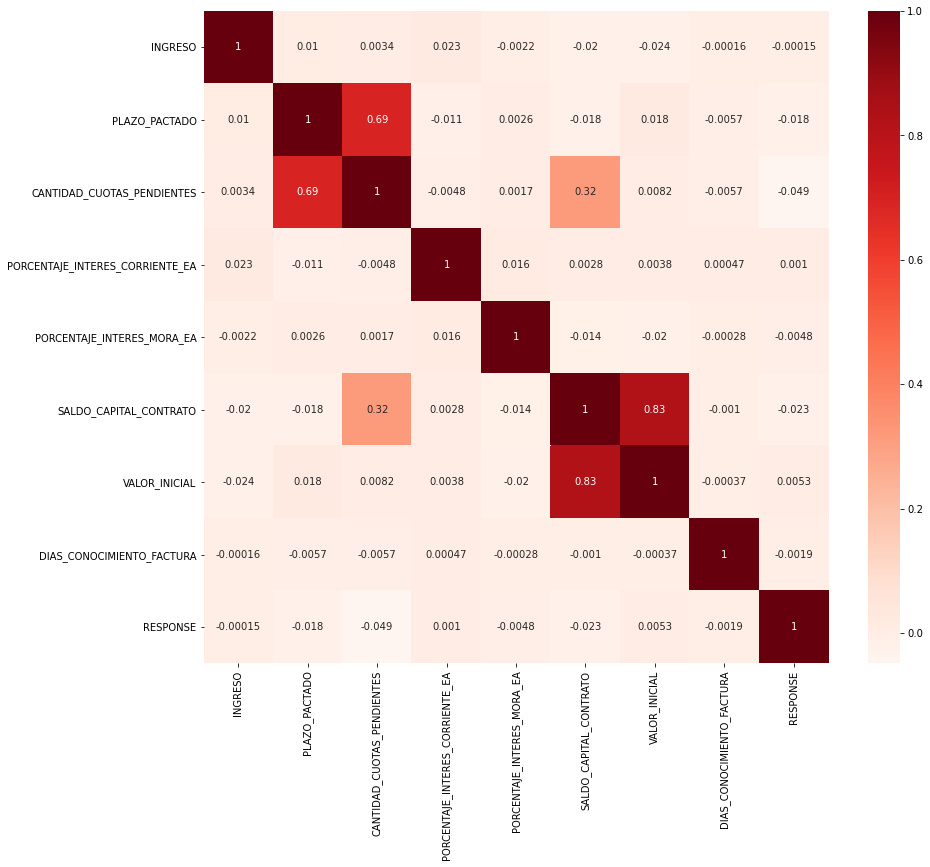

In [32]:
plt.figure(figsize=(14,12))
sns.heatmap(correlation_data.corr(method='pearson'), annot=True, cmap=plt.cm.Reds)
plt.savefig("Correlacion")

Debe de respetarse las suposiciones de la regresión lineal y esta es que las variables independientes no deben estar correlacionadas, en este caso debemos considerar las que esten menos correlacionadas entre sí. Se verifica entonces la correlacion entre características resultantes después del filtro



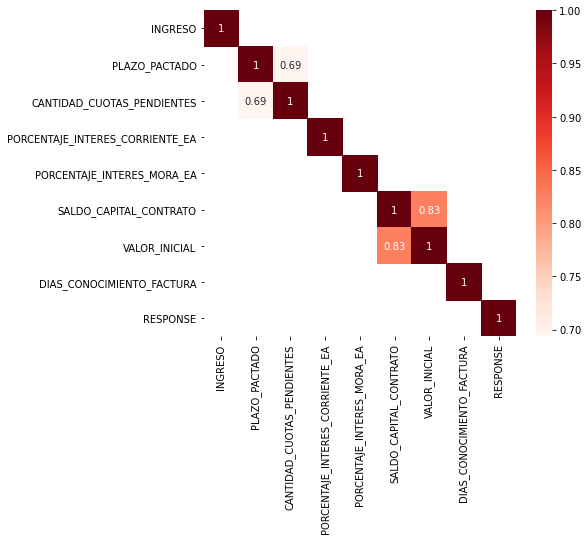

In [33]:
plt.figure(figsize=(7,6))

cor_t = correlation_data.corr()

sns.heatmap(cor_t[cor_t >0.5], annot=True, cmap=plt.cm.Reds)

Después de la elección de variables se añaden a la variable principal que almacena la base de datos principal

In [34]:
# esto es provisional, se debe descartar bien las variables
Xn = correlation_data.drop(["RESPONSE"], axis=1)
y = correlation_data["RESPONSE"].to_numpy()
X = np.concatenate((X, Xn.to_numpy()), axis=1)
print("Tamaño de la matriz de entrenamiento = {}".format(X.shape))
print("Tamaño del vector objetivo= {}".format(y.shape))

Tamaño de la matriz de entrenamiento = (182779, 1114)
Tamaño del vector objetivo= (182779,)


## Construcción de modelo

Se realiza la partición de los datos para poder medir las métricas de rendimiento, de esta manera consolidar el mejor modelo posible. Se realiza la separación de datos de la siguiente manera

> +  **Datos de entrenamiento($60\%$):** Datos para entrenar el modelo
+**Datos de validacion($20\%)$:** Muestra de datos usada para medir el rendimento del modelo, basado en este indicador se ajustan los hiperparámtros de los modelos y así tratar de conseguir el mejod modelo
+**Datos de prueba($20\%$):** Datos que el modelo nunca ha visto y con estos se busca probar el desempeño 

Se separan los datos

In [35]:
%load_ext autoreload
%autoreload 2

X_train, X_test, X_val, y_train, y_test, y_val = split_stratified(X, y)

print("% de datos en el conjunto de entrenamiento = {}".format(len(X_train)/len(X)*100))
print("% de datos en el conjunto de validación    = {}".format(len(X_val)/len(X)*100))
print("% de datos en el conjunto de test          = {}".format(len(X_test)/len(X)*100))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
% de datos en el conjunto de entrenamiento = 59.99978115647859
% de datos en el conjunto de validación    = 15.00008206632053
% de datos en el conjunto de test          = 25.000136777200883


### Cambio de escala de datos

Se procede a escalar los datos, ya que todos los valores no están en la misma escala, para esto se tiene tres conceptos

>**Normalización:** Cambio en la escala de atributos numéricos de valor real en un rango de 0 a 1

>**Estandarización:** Cambio de la distribución de cada atributo para tener una media de cero y una desviación estándar de uno (varianza unitaria). A cada valor en el conjunto de datos se le restará el valor medio y luego se dividirá por la devación estándar de todo el conjunto de datos. Esto puede verse influenciado por valores atípicos (si existen en el conjunto de datos), ya que implica la estimación de la media empírica y la desviación estándar de cada característica.

$$z = \frac{x-\mu}{\sigma} \qquad \mu = \frac{1}{N}\sum_{i=1}^{N}(x_{i})\qquad \sigma = \sqrt{\frac{1}{N}\sum_{i=1}^{N}(x_{i}-\mu)^{2}}$$

Se hace estandarización de los datos para facilitar el cálculo numérico y poder medir las métricas correctamente


In [ ]:
scaler = StandardScaler()
scaler.fit(X)
scaler.transform(X)

In [38]:
params = {"booster":"gbtree", 
          "eta": 0.05, 
          "alpha":0.5,
          "gamma":5,
          "silent":1,
          "objective":"binary:logistic",
          "eval_metric":"auc",
          "colsample_bytree":0.8,
          "subsample":1,
          "use_label_encoder":False,
         }

xgb_model = XGBClassifier(**params, scale_pos_weight=3.8)


In [39]:
xgb_model.fit(X_train, 
              y_train,
              eval_set=[(X_train, y_train),(X_test, y_test)],
              eval_metric=["error", "auc"],
              early_stopping_rounds=30
             )

[14:55:16] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.00871	validation_0-auc:0.70182	validation_1-error:0.00919	validation_1-auc:0.68654
[1]	validation_0-error:0.00869	validation_0-auc:0.70657	validation_1-error:0.00897	validation_1-auc:0.68719
[2]	validation_0-error:0.00861	validation_0-auc:0.71182	validation_1-error:0.00889	validation_1-auc:0.68950
[3]	validation_0-error:0.00864	validation_0-auc:0.73680	validation_1-error:0.00880	validation_1-auc:0.71591
[4]	validation_0-error:0.00863	validation_0-auc:0.74143	validation_1-error:0.00884	validation_1-auc:0.71613
[5]	validation_0-error:0.

XGBClassifier(alpha=0.5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eta=0.05,
              eval_metric='auc', gamma=5, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.0500000007,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0.5, reg_lambda=1,
              scale_pos_weight=3.8, silent=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, ...)

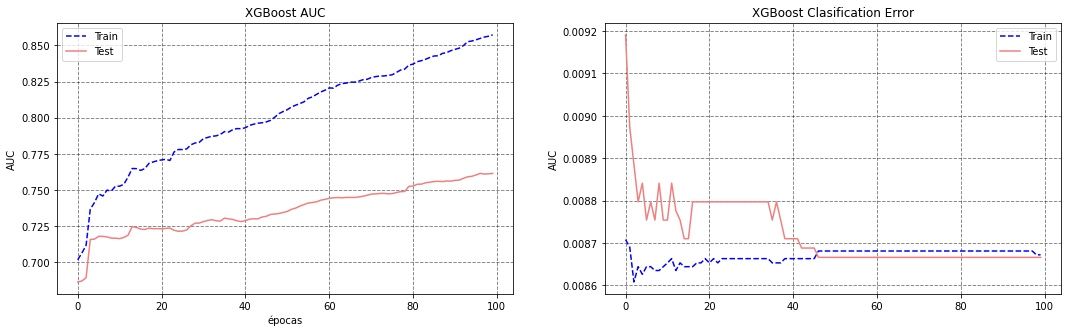

In [113]:
results = xgb_model.evals_result()
epoch   = len(results["validation_0"]["error"])
x_axis  = range(0, epoch)

fig = plt.figure(figsize=(18,5))

plt.subplot(121)
plt.plot(x_axis, results["validation_0"]["auc"], "b--",label="Train")
plt.plot(x_axis, results["validation_1"]["auc"], "lightcoral", label="Test")
plt.legend()
plt.ylabel("AUC")
plt.xlabel("épocas")
plt.title("XGBoost AUC")
plt.grid(color='k', alpha=0.5, linestyle='dashed', linewidth=0.9)

plt.subplot(122)
plt.plot(x_axis, results["validation_0"]["error"], "b--",label="Train")
plt.plot(x_axis, results["validation_1"]["error"], "lightcoral",label="Test")
plt.legend()
plt.ylabel("AUC")
plt.title("XGBoost Clasification Error")
plt.grid(color='k', alpha=0.5, linestyle='dashed', linewidth=0.9)



Las métricas de evaluación se ven bien, sin embargo debe hacerse un análisis más cuidadoso. Se define "accuracy_binary" como la relación entre las predicciones correctas (Suma de verdaderos positivos y negativos) y las predicciones totales. Esta devuelve el porcentaje de predicciones correctas. El clasificador ideal tendría una exactitud de 1 (todas las muestras están bien clasificadas) y el peor posible tendría un "accuracy" de 0 (Ninguna muestra bien clasificada).


In [102]:
print("Accuracy = {}".format(accuracy_score(y_test, xgb_model.predict(X_test))))

Accuracy = 0.9991902834008097


Evidentemente esta métrica muestra un gran desempeño, sin embargo se debe contrastar con otro método. Para este propósito se utiliza la matriz de confusión para el conjunto de test

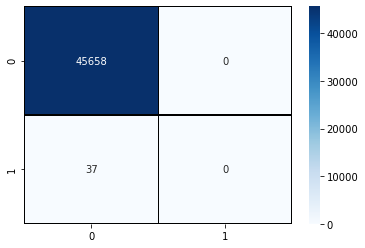

In [100]:
sns.heatmap(confusion_matrix(y_test, xgb_model.predict(X_test)), 
            annot=True,
            cmap=plt.cm.Blues,
            fmt="g",
            linecolor='black',
            linewidths=0.2
           )

Esto evidencia que el algoritmo clasifica perfectamente a los no morosos, pero es absolutamente deficiente cuando se trata de clasificar a los morosos, que es el caso de interés. Para ratificar la hipótesis se utiliza el modelo con datos que no conoce el modelo y se analiza como clasifica

In [103]:
accuracy_score(y_val, xgb_model.predict(X_val))

0.9913192544771492

al igual tiene un alto rendimiento en el "accuracy"

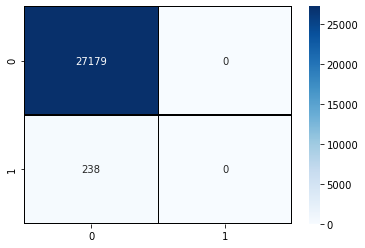

In [104]:
sns.heatmap(confusion_matrix(y_val, xgb_model.predict(X_val)), 
            annot=True,
            cmap=plt.cm.Blues,
            fmt="g",
            linecolor='black',
            linewidths=0.2
           )

Esto refuerza la hipótesis que se planteó anteriormente. El modelo no sabe clasificar a los morosos. Para los datos de validación clasifica 238 no morosos como morosos. Esto nos lleva a un caso de la paradoja de la presición, como se evidencia, la razón por la que obtenemos un 99% de precisión en datos desequilibrados (con el 99% de las instancias en la Clase 0) es porque el modelo mira los datos y decide inteligentemente que lo mejor es predecir siempre "No morosos" y lograr una alta precisión.


## Problema de desbalanceo

Se puede tener un problema de desbalanceo en la base de datos para la variable objetivo, veamos la relación de desbalanceo

In [129]:
values1 = len(DATA["RESPONSE"][DATA["RESPONSE"] == 1])
values0 = len(DATA["RESPONSE"][DATA["RESPONSE"] == 0])

print("La relación es que por cada valor 1 existen paroximadamente {} valores de 0".format(int(values0/values1)))


La relación es que por cada valor 1 existen paroximadamente 114 valores de 0


Este es un conjunto de datos desbalanceado y la proporcion de la clase 1 a la calse 0 es de 1:144. 

## Modelo 2

In [92]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, StackingClassifier)

from sklearn.metrics import (mean_squared_log_error, 
                             mean_squared_error,
                             r2_score,
                             mean_absolute_error,
                             accuracy_score,
                             recall_score,
                             f1_score, precision_score,
                             plot_confusion_matrix,
                             roc_curve, auc,confusion_matrix
                            )

import pickle

In [84]:
clfs = [("Bernoulli", BernoulliNB(alpha=0.5)),
        
        ("LR", LogisticRegression(solver="liblinear",
                                  class_weight="balanced",
                                  random_state=11)),
        ("Forest", RandomForestClassifier(random_state=11))]

In [87]:
clf = StackingClassifier(estimators=clfs,
                         final_estimator=LogisticRegression())
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)



In [90]:
print("Accuracy:    ", accuracy_score(y_test, y_pred))
print('Recall:    ', recall_score(y_test, y_pred))
print('F1-Score:    ', f1_score(y_test, y_pred))
print('Precision:  ', precision_score(y_test, y_pred))


Accuracy:     1.0
Recall:     1.0
F1-Score:     1.0
Precision:   1.0


In [93]:
with open("metamodelo.pkl", "wb") as handle:
    pickle.dump(clf, handle, pickle.HIGHEST_PROTOCOL)

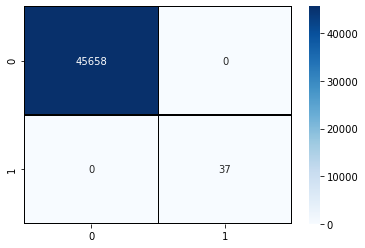

In [94]:
sns.heatmap(confusion_matrix(y_test,y_pred), 
            annot=True,
            cmap=plt.cm.Blues,
            fmt="g",
            linecolor='black',
            linewidths=0.2
           )

In [98]:
print("Accuracy:    ", accuracy_score(y_val, clf.predict(X_val)))
print('Recall:    ', recall_score(y_val, clf.predict(X_val)))
print('F1-Score:    ', f1_score(y_val, clf.predict(X_val)))
print('Precision:  ', precision_score(y_val, clf.predict(X_val)))

Accuracy:     0.9906627275048328
Recall:     0.01680672268907563
F1-Score:     0.0303030303030303
Precision:   0.15384615384615385


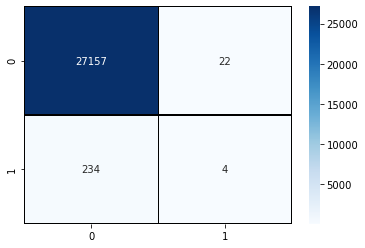

In [99]:
sns.heatmap(confusion_matrix(y_val,clf.predict(X_val)), 
            annot=True,
            cmap=plt.cm.Blues,
            fmt="g",
            linecolor='black',
            linewidths=0.2
           )